In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
plt.rcparams = {"fontsize": 16}

fig_params = {"dpi": 100, "figsize": (7, 7)}

In [2]:
# Количество приемных устройств
K = 25

# Расстояние между приемниками
d = 0.7
d1 = 2 * np.pi * d


M = 2 * K

# k - волновое число
k = 2 * np.pi

# ND
ND = 100 / (2 * K + 1)
ND = 1

# Один радиан в градусах
rad_in_grad = 180 / np.pi 

# Отход от центра наблюдения целей
s = 1/ (0.82 * (M + 1) * d * 2)
s1 = 1.4 * s
dt = 0.1 * s
ds = 0.2 * s
ds1 = 0.01 * s1
sss = 0.01

# Сетки
dtn = np.arange(-s, s + dt, dt)
a = np.arange(-s1, s1 + ds1, ds1)
a1 = np.arange(0, 0.125 * k + ds, ds)

In [3]:
def F(t, alpha = 0):
    result = 0
    for n in np.arange(1, K + 1):
        result += np.cos(k * d * n * (t - alpha))
    return result * 2 * ND + ND

def Fexp(t, alpha = 0):
    result = 0 + 0j
    for n in np.arange(0, K):
        result += np.exp(-1j * (k * d * (n - K) * (t - alpha))) + np.exp(1j * (k * d * (n - K) * (t - alpha))) 
    return result * ND + ND

In [4]:
def gauss_func(x, mean=0, var=1):
    return 1/(np.pi * 2 * np.sqrt(var)) * np.exp(-(x - mean)**2/(2 * var))

def signal_func(x, pos = [0.15, 0.45], var = 0.000001, magnitude = 600):
    pos = np.array(pos)
    var = np.array(var)
    signal = np.zeros_like(x)
    for idx, target in enumerate(pos):
        signal += gauss_func(x, target, var)
    return signal / np.max(signal) * magnitude

In [5]:
magnitude = 600
targets = [-0.02, 0.02]

Idel = lambda t: signal_func(t, pos = targets, magnitude = magnitude)

In [6]:
def integrand(t, alpha):
    return np.real(Fexp(t - alpha)) * Idel(t)

def U00(a):
    return integrate.quad(integrand, -s1, s1, args = (a, ))[0]

vec_U00 = np.vectorize(U00)

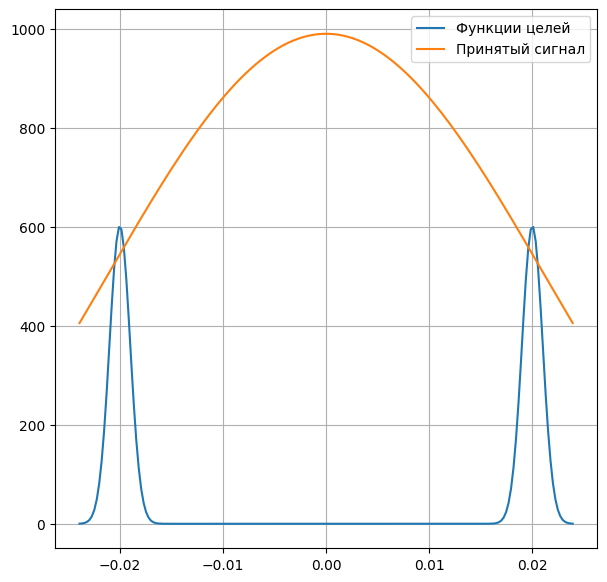

In [7]:
plt.figure(**fig_params)
plt.plot(a, Idel(a), label = "Функции целей")
plt.plot(a, vec_U00(a), label = "Принятый сигнал")
plt.legend()
plt.grid()
plt.show()

In [8]:
NP = 200
NPa = np.arange(0, NP + 1)

In [9]:
def integrand_Cn(t, n = 1):
    return np.cos(k * d * n * t) * Idel(t)

In [10]:
def integral_of_func(func, lower = -1, upper = 1, N = 1000, **kwargs):
    h = (upper - lower) / N
    array_1d = np.arange(lower + h, upper + h, h)
    result = np.sum(func(array_1d, **kwargs) * h)
    return result 

In [11]:
int_func = np.vectorize(integral_of_func)

In [12]:
Cn = int_func(func=integrand_Cn, lower = -1, upper=1, N = 20000, n = NPa)

In [13]:
C = Cn[:K+1]
CR = Cn[K+1:]

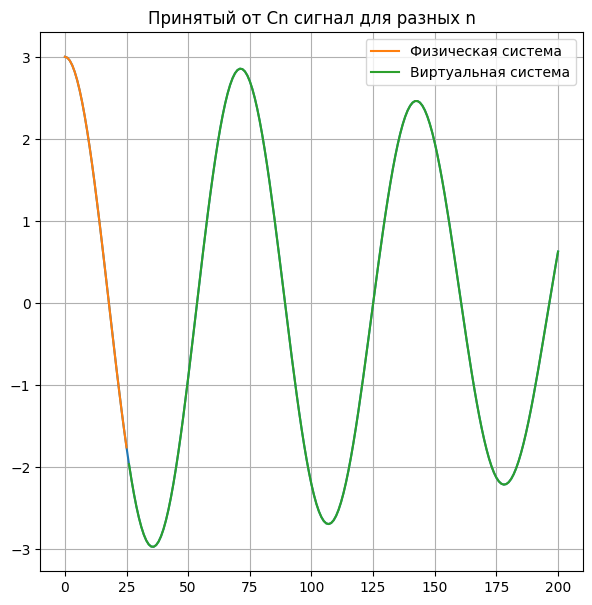

In [14]:
plt.figure(**fig_params)
plt.title("Принятый от Cn сигнал для разных n")
plt.plot(NPa, Cn)
plt.plot(NPa[:K+1], C, label = "Физическая система")
plt.plot(NPa[K+1:], CR, label = "Виртуальная система")
plt.legend()
plt.grid()

## Модель затухающих колебаний

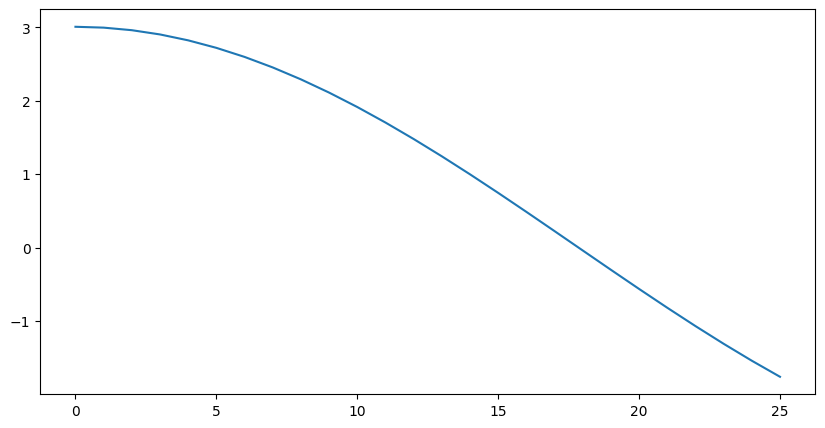

In [15]:
signal = lambda x, A, alpha, beta, epsilon: A * np.exp(alpha * x) * np.sin(beta * x + epsilon)
data = np.vstack([NPa[:K+1], C])

plt.figure(figsize = (10, 5))
plt.plot(data[0], data[1])
plt.show()

In [16]:
def grad_signal(x, data, A, alpha, beta, epsilon, clip = 255):
    grad = np.zeros(4)
    errors = signal(x, A, alpha, beta, epsilon) - data
    grad[0] = np.sum(errors * np.exp(alpha * x) * np.sin(beta * x + epsilon))
    grad[1] = np.sum(errors * A * x * np.exp(alpha * x) * np.sin(beta * x + epsilon))
    grad[2] = np.sum(errors * A * np.exp(alpha * x) * np.cos(beta * x + epsilon) * x)
    grad[3] = np.sum(errors * A * np.exp(alpha * x) * np.cos(beta * x + epsilon))
    return np.clip(grad / len(x), -clip, clip)

In [17]:
params_0 = np.array([data[1, 0], 0, 0 , 1.57])
params = np.zeros(4)
n_steps = 20000
speed = 0.001

num_of_data = data.shape[1]
batch_size = num_of_data // 1

for step in np.arange(n_steps):
    for start_index in range(0, num_of_data, batch_size):
        x_batch = data[0, start_index:start_index + batch_size]
        y_batch = data[1, start_index:start_index + batch_size]
        params = params_0 - speed * grad_signal(x_batch, y_batch, 
                                                params_0[0],
                                                params_0[1],
                                                params_0[2],
                                                params_0[3])
    params_0 = params

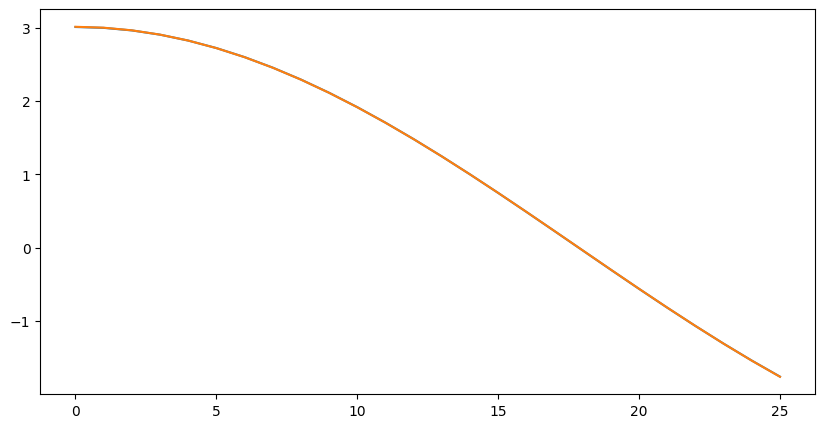

array([ 3.01106901e+00, -1.69721422e-04, -8.78360134e-02,  1.56883209e+00])

In [18]:
plt.figure(figsize = (10, 5))
plt.plot(data[0], data[1])
plt.plot(data[0], signal(data[0], params[0], params[1], params[2], params[3]))
plt.show()
params

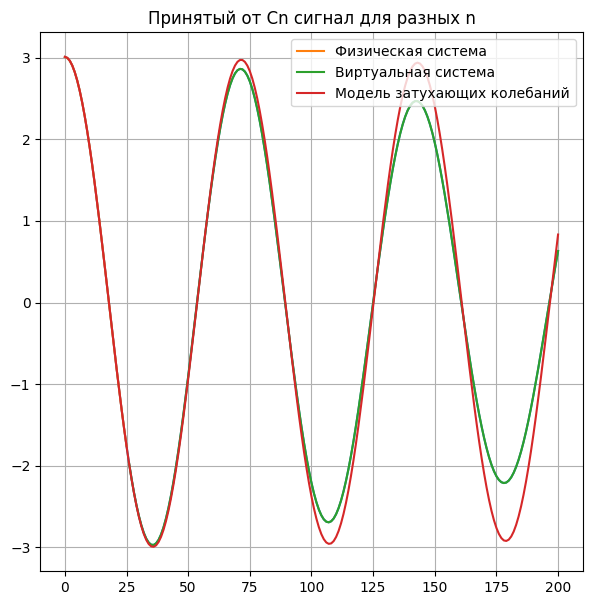

In [19]:
Cn_model = signal(NPa, params[0], params[1], params[2], params[3])

plt.figure(**fig_params)
plt.title("Принятый от Cn сигнал для разных n")
plt.plot(NPa, Cn)
plt.plot(NPa[:K+1], C, label = "Физическая система")
plt.plot(NPa[K+1:], CR, label = "Виртуальная система")
plt.plot(NPa, Cn_model,
        label = "Модель затухающих колебаний")
plt.legend()
plt.grid()

In [20]:
def rel_squared_error(x, y):
    return np.sum((x - y) ** 2) / np.sum(x**2)

def rel_abs_error(x, y):
    return np.sum(np.abs(x - y)) / np.sum(np.abs(x))

def MAE(x, y):
    return np.sum(np.abs(x - y)) / x.shape[0]

def MSE(x, y):
    return np.sum(np.power(x - y, 2)) / x.shape[0]

print(f"Относительная ошибка по квадратам: {rel_squared_error(Cn, Cn_model)}")
print(f"Относительная ошибка по модулям: {rel_abs_error(Cn, Cn_model)}")
print(f"Средний модуль ошибки: {MAE(Cn, Cn_model)}")
print(f"Средний квадрат ошибки: {MSE(Cn, Cn_model)}")

Относительная ошибка по квадратам: 0.021109469693123693
Относительная ошибка по модулям: 0.11012694143263638
Средний модуль ошибки: 0.18477832534426383
Средний квадрат ошибки: 0.07510474053605468


## Моделирование приемной системы

In [21]:
def CnU(x, Cn):
    result = 0
    for n, c in enumerate(Cn[1:]):
        result += c * np.exp(-1j * (k * d * (n + 1) * (x))) + c * np.exp(1j * (k * d * (n + 1) * (x)))
    return result + Cn[0] * np.exp(1j * (k * d * (0) * (x)))

In [22]:
Result = CnU(a, Cn_model)

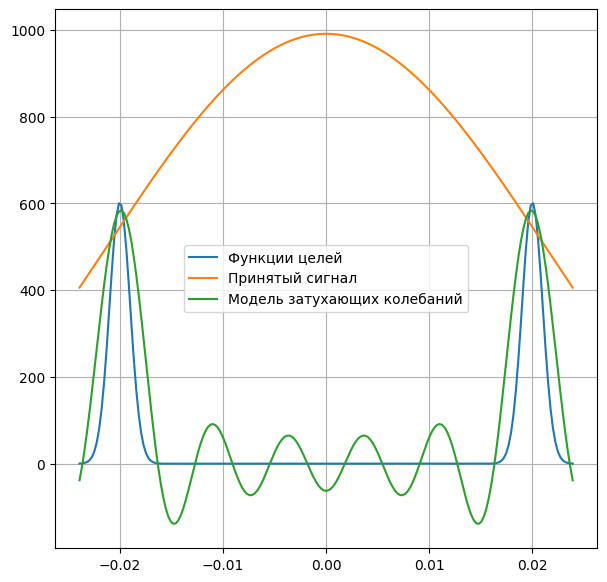

In [23]:
plt.figure(**fig_params)
plt.plot(a, Idel(a), label = "Функции целей")
plt.plot(a, vec_U00(a), label = "Принятый сигнал")
plt.plot(a, np.real(Result), label = "Модель затухающих колебаний")
plt.legend()
plt.grid()
plt.show()

## Полносвязная нейронная сеть

In [24]:
from sklearn.neural_network import MLPRegressor

In [31]:
regr = MLPRegressor(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(18), random_state=1, activation = "tanh")

In [32]:
regr.fit(data[0].reshape(-1, 1), data[1])

C:\Program Files\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(activation='tanh', alpha=1e-05, hidden_layer_sizes=18,
             random_state=1, solver='lbfgs')

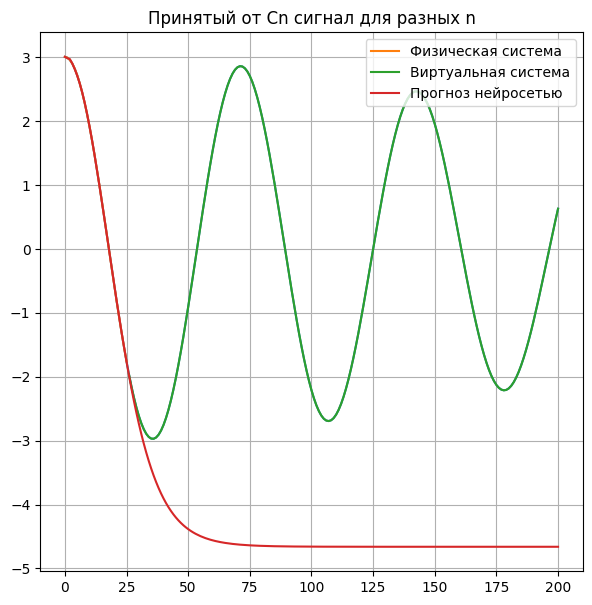

In [33]:
plt.figure(**fig_params)
plt.title("Принятый от Cn сигнал для разных n")
plt.plot(NPa, Cn)
plt.plot(NPa[:K+1], C, label = "Физическая система")
plt.plot(NPa[K+1:], CR, label = "Виртуальная система")
plt.plot(NPa, regr.predict(NPa.reshape(-1, 1)), label = "Прогноз нейросетью")
plt.legend()
plt.grid()